In [49]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'INP file examples\\chem_Otomo2018_without_O_FIXED_by_Cantera.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages

# import inp_data_extractor.py as inp:
try:
    import inp_data_extractor as inp
except ImportError:
    try:
        from Bubble_dynamics_simulation import inp_data_extractor as inp
    except ImportError as error:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
        raise error
    except Exception as error:
        print(colored(f'Error, \'inp_data_extractor.py\' failed to load', 'red'))
        raise error
except Exception as error:
    print(colored(f'Error, \'inp_data_extractor.py\' failed to load', 'red'))
    raise error
importlib.reload(inp)   # reload changes you made

# create parameters.py
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=INP file examples\chem_Otomo2018_without_O_FIXED_by_Cantera.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 63 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 63 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O_FIXED_by_Cantera
File 'parameters.py' succesfully created
chem_Otomo2018_witho

In [50]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made

# import full_bubble_model.py as de:
_already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except ImportError:
    try:
        from  Bubble_dynamics_simulation import full_bubble_model as de
    except ImportError as _error:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
        raise _error
    except Exception as _error:
        print(colored(f'Error, \'full_bubble_model.py\' failed to load', 'red'))
        raise _error
except Exception as _error:
    print(colored(f'Error, \'full_bubble_model.py\' failed to load', 'red'))
    raise _error
if _already_imported: importlib.reload(de)   # reload changes you made

model: chem_Otomo2018_without_O_FIXED_by_Cantera
target specie: NH3
excitation: sin_impulse (control parameters: ['p_A', 'freq', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [59]:
"""Specify optimal point"""

best_point = dict(
    ID = 0,                                      # ID of control parameter (not used during calculation)
  # Initial conditions:
    R_E =  0.00008484,                           # bubble equilibrium radius [m]
    ratio =  1.00,                               # initial radius / equilibrium radius R_0/R_E [-]
    gases = [par.index['N2'], par.index['H2']],  # indexes of species in initial bubble (list of species indexes)
    fractions = [0.25, 0.75],                    # molar fractions of species in initial bubble (list of fractions for every gas)
  # Ambient parameters:
    P_amb =  101325.00,                          # ambient pressure [Pa]
    T_inf =  303.15,                             # ambient temperature [K]
  # Liquid parameters:
    alfa_M =  0.3500,                            # water accommodation coefficient [-]
    P_v =  4245.13,                              # vapour pressure [Pa]
    mu_L =  0.00081486,                          # dynamic viscosity [Pa*s]
    rho_L =  998.20,                             # density [kg/m^3]
    c_L =  1483.00,                              # sound speed [m/s]
    surfactant =  1.00,                          # surfactant (surface tension modfier) [-]
  # Excitation parameters: (excitation_type = sin_impulse_logf)
    p_A = -187401.99765485013,                   # [Pa]
    freq = 12000.0,                              # [-]
    n = 1.0,                                     # [-]
)

best_point['P_v'] = de.VapourPressure(best_point['T_inf'])   # vapour pressure [Pa]
best_point['mu_L'] = de.Viscosity(best_point['T_inf'])       # dynamic viscosity [Pa*s]

## Single plot

You have one control parameter along the x axis, all the others are kept constant. <br>
The y axis is some output calculated from the simulation, like the amount of hydrogen created, energy put in. <br>
In this example: <br>
* **x**: Equilibrium radius or $R_E\ [\mu m]$ <br>
* **y**: Energy requirement for the production of 1 kg hydrogen or $E\ [MJ/kg]$ <br>

In [60]:
"""Control parameters"""

# Equilibrium radius: [um --> m]
parname = 'R_E'
ranges = [1e-6*x for x in list(np.linspace(5.0, 150.0, 50))]

# list all cpar combinations you want to plot:
cpars = []
for ID, value in enumerate(ranges):
    cpar = de.copy(best_point)
    cpar[parname] = value
    cpar['ID'] = ID + 1
    cpar['P_v'] = de.VapourPressure(T=cpar['T_inf']) # [Pa]
    cpar['mu_L'] = de.Viscosity(T=cpar['T_inf']) # [Pa*s]
    cpars.append(cpar)
    
# Create input dictionary for de.simulate(), a list of dictionaries with cpar and other arguments
kwargs_list = [dict(cpar=cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=30, Radau_timeout=300) for cpar in cpars]

In [61]:
"""Run simulations, multithread"""
# calculate E [MJ/kg] for each R_E
# use Pool(processes=cpu_count()-1) to limit number of threads being used.
# use pool.imap(...) instead of pool.imap_unordered(...) to preserve order in which cpars was made

# empty lists to store values on x and y axises:
x = []
y = []

best_energy = 1e30
start = time.time()
with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
    results = pool.imap(de.simulate, kwargs_list)

    for data in results:
        # store results in x and y, if they are valid:
        data = de.dotdict(data)
        if data.success==True and data.energy_demand==data.energy_demand: # if simulation is succesfull, and energy is not NaN
            if data.energy_demand<0: data.energy_demand=1e30
            x.append(data[parname])
            y.append(data.energy_demand)
        # print stuff:
        if data.energy_demand>0 and data.energy_demand<best_energy:
            best_energy = data.energy_demand
        excitation_params = ''.join([f'{key}={data[key]: <12}; ' for key in de.excitation_args])
        print(f'index: {data.ID: >8}/{len(cpars)};   error_code: {data.error_code: >4};   steps: {data.steps: <8};   runtime: {data.elapsed_time: 6.2f} [s]   |   '+
              f'R_E={1e6*data.R_E: 6.2f} [um]; ratio={data.ratio: 6.2f} [-]; P_amb={1e-5*data.P_amb: 6.2f} [bar]; T_inf={data.T_inf-273.15: 6.2f} [°C]; '+
              f'alfa_M={data.alfa_M: 6.2f} [-]; P_v={data.P_v: 6.0f} [Pa]; mu_L={data.mu_L: 6.5f} [Pa*s]; rho_L={data.rho_L: 6.1f} [kg/m^3]; c_L={data.c_L: 6.0f} [m/s]; '+
              f'surfactant={100*data.surfactant: 3.0f} [%]   |   {excitation_params}   |   '+
              f'{de.target_specie} production: {data.energy_demand: e} [MJ/kg]'+
              '                                                 ', end='\r')
            
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / len(cpars)): .2f} [s/run])')
print(f'succes: {len(x)}/{len(ranges)}')

index:       50/50;   error_code:    0;   steps: 15665   ;   runtime:   1.26 [s]   |   R_E= 150.00 [um]; ratio=  1.00 [-]; P_amb=  1.01 [bar]; T_inf= 30.00 [°C]; alfa_M=  0.35 [-]; P_v=  4245 [Pa]; mu_L= 0.00081 [Pa*s]; rho_L= 998.2 [kg/m^3]; c_L=  1483 [m/s]; surfactant= 100 [%]   |   p_A=-187401.99765485013; freq=12000.0     ; n=1.0         ;    |   NH3 production:  3.596903e+05 [MJ/kg]                                                 

DONE
total time:  0 hours  2 mins
             94.68 [s]   ( 1.89 [s/run])
succes: 47/50


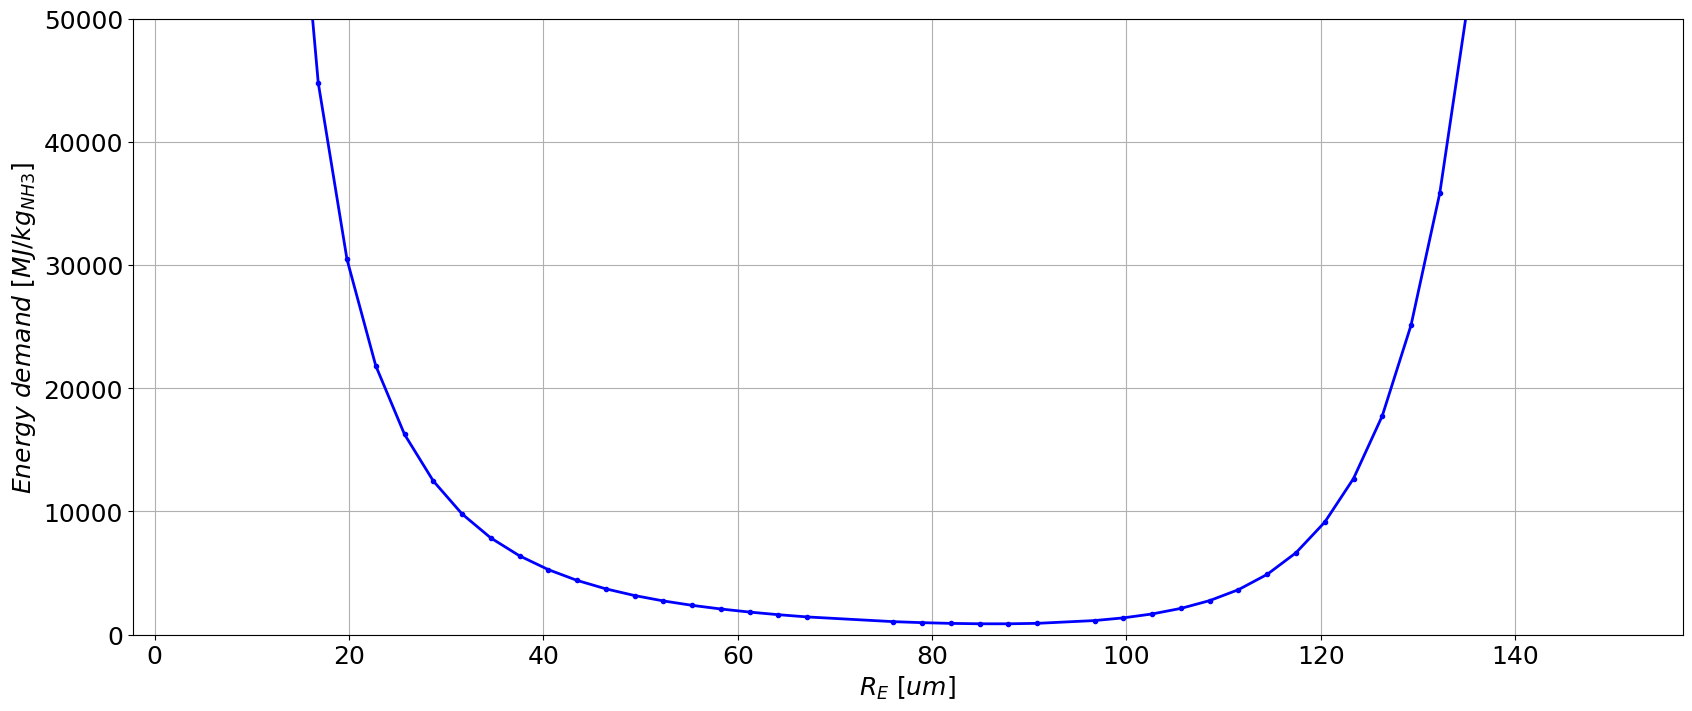

In [62]:
"""plot the results (and save it as .png)"""

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(1e6*np.array(x), y, '.-', color='b', linewidth=2.0)
ax.set_ylabel('$Energy\ demand\ [MJ/kg_{' + de.target_specie + '}]$')
ax.set_xlabel('$R_E \ [um]$')
ax.set_ylim([0, min(max(y), 5e4)])
#ax.set_yscale('log')
ax.grid()

if False: # save as image by setting it True (don't forget to create folder named 'images')
    fig.savefig('images\\R_E-Energy-plot.png')

## Subplots
You have a fixed point in the control parameter space, e.g. the global optimum for E [MJ/kg]. An each subplot, one control parameter is changed, similarly to the previous examply, while the rest remains constant. This way you can visualize
You have one control parameter along the x axis, all the others are kept constant. <br>
The y axis is the same, as before.

In [63]:
"""Control parameters"""

# control parameter points to examine:
ranges = dict(
    R_E=[1e-6*x for x in list(np.linspace(5.0, 150.0, 50))], # [um --> m]
    P_amb=[1e5*x for x in np.linspace(0.05, 1.5, 50)], # [bar --> Pa]
    #alfa_M=np.linspace(0.05, 0.4, 8), # [-]
    T_inf=[273.15+x for x in np.linspace(5.0, 50.0, 20)], # [°C --> K]
    surfactant=np.linspace(0.25, 2.0, 8), # [-]
    c_L=[x*par.c_L for x in np.linspace(0.5, 2.0, 30)], # [-]
    rho_L=[x*par.rho_L for x in np.linspace(0.5, 2.0, 20)], # [-]
)

# for plot labels:
labels = dict(
    R_E='$R_E\ [\mu m]$',
    ratio='$R_0/R_E\ [-]$',
    P_amb='$P_\infty\ [bar]$',
    alfa_M='$α_M\ [-]$',
    T_inf='$T_\infty\ [°C]$',
    surfactant='$surfactant\ [\%]$',
    c_L='$c_L\ [m/s]$',
    rho_L='$\\rho_L\ [kg/m^3]$',
)

# list all cpar combinations you want to plot:
kwargs_list = []
ID = 1
for key in ranges:
    cpars = []
    for value in ranges[key]:
        cpar = de.copy(best_point)  # deep copy other_cpars
        cpar[key] = value
        cpar['ID'] = ID
        ID += 1
        cpar['P_v'] = de.VapourPressure(T=cpar['T_inf']) # [Pa]
        cpar['mu_L'] = de.Viscosity(T=cpar['T_inf']) # [Pa*s]
        cpars.append(cpar)
    # Create input dictionary for de.simulate(), a list of dictionaries with cpar and other arguments
    kwargs_list.append([dict(cpar=cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=30, Radau_timeout=300) for cpar in cpars])

In [64]:
"""Run simulations, multithread"""
# calculate E [MJ/kg] for each combinations
# use Pool(processes=cpu_count()-1) to limit number of threads being used.
# use pool.imap(...) instead of pool.imap_unordered(...) to preserve order in which cpars was made

# empty lists to store values on x and y axises:
x = []
y = []

fixed_energy = de.simulate(dict(cpar=best_point, t_int=np.array([0.0, 1.0]), LSODA_timeout=300, Radau_timeout=30))['energy_demand']
best_energy = 1e30
num = sum([len(x) for x in kwargs_list])
start = time.time()
for i, key in enumerate(ranges):
    subx = []
    suby = []
    with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
        results = pool.imap(de.simulate, kwargs_list[i])

        for data in results:
            # store results in x and y, if they are valid:
            data = de.dotdict(data)
            if data.success==True and data.energy_demand==data.energy_demand: # if simulation is succesfull, and energy is not NaN
                if data.energy_demand<0: data.energy_demand=1e30
                subx.append(data[key])
                suby.append(data.energy_demand)
            # print stuff:
            if data.energy_demand>0 and data.energy_demand<best_energy:
                best_energy = data.energy_demand
            excitation_params = ''.join([f'{key}={data[key]: <12}; ' for key in de.excitation_args])
            print(f'index: {data.ID: >8}/{num};   error_code: {data.error_code: >4};   steps: {data.steps: <8};   runtime: {data.elapsed_time: 6.2f} [s]   |   '+
                f'R_E={1e6*data.R_E: 6.2f} [um]; ratio={data.ratio: 6.2f} [-]; P_amb={1e-5*data.P_amb: 6.2f} [bar]; T_inf={data.T_inf-273.15: 6.2f} [°C]; '+
                f'alfa_M={data.alfa_M: 6.2f} [-]; P_v={data.P_v: 6.0f} [Pa]; mu_L={data.mu_L: 6.5f} [Pa*s]; rho_L={data.rho_L: 6.1f} [kg/m^3]; c_L={data.c_L: 6.0f} [m/s]; '+
                f'surfactant={100*data.surfactant: 3.0f} [%]   |   {excitation_params}   |   '+
                f'{de.target_specie} production: {data.energy_demand: e} [MJ/kg]'+
                '                                                 ', end='\r')
    x.append(subx)
    y.append(suby)
            
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / num): .2f} [s/run])')
good = sum([len(x) for x in x])
print(f'succes: {good}/{num}')

index:      178/178;   error_code:    0;   steps: 14174   ;   runtime:   0.98 [s]   |   R_E= 84.84 [um]; ratio=  1.00 [-]; P_amb=  1.01 [bar]; T_inf= 30.00 [°C]; alfa_M=  0.35 [-]; P_v=  4245 [Pa]; mu_L= 0.00081 [Pa*s]; rho_L= 1996.4 [kg/m^3]; c_L=  1483 [m/s]; surfactant= 100 [%]   |   p_A=-187401.99765485013; freq=12000.0     ; n=1.0         ;    |   NH3 production:  4.167749e+03 [MJ/kg]                                                 

DONE
total time:  0 hours  4 mins
             258.11 [s]   ( 1.45 [s/run])
succes: 167/178


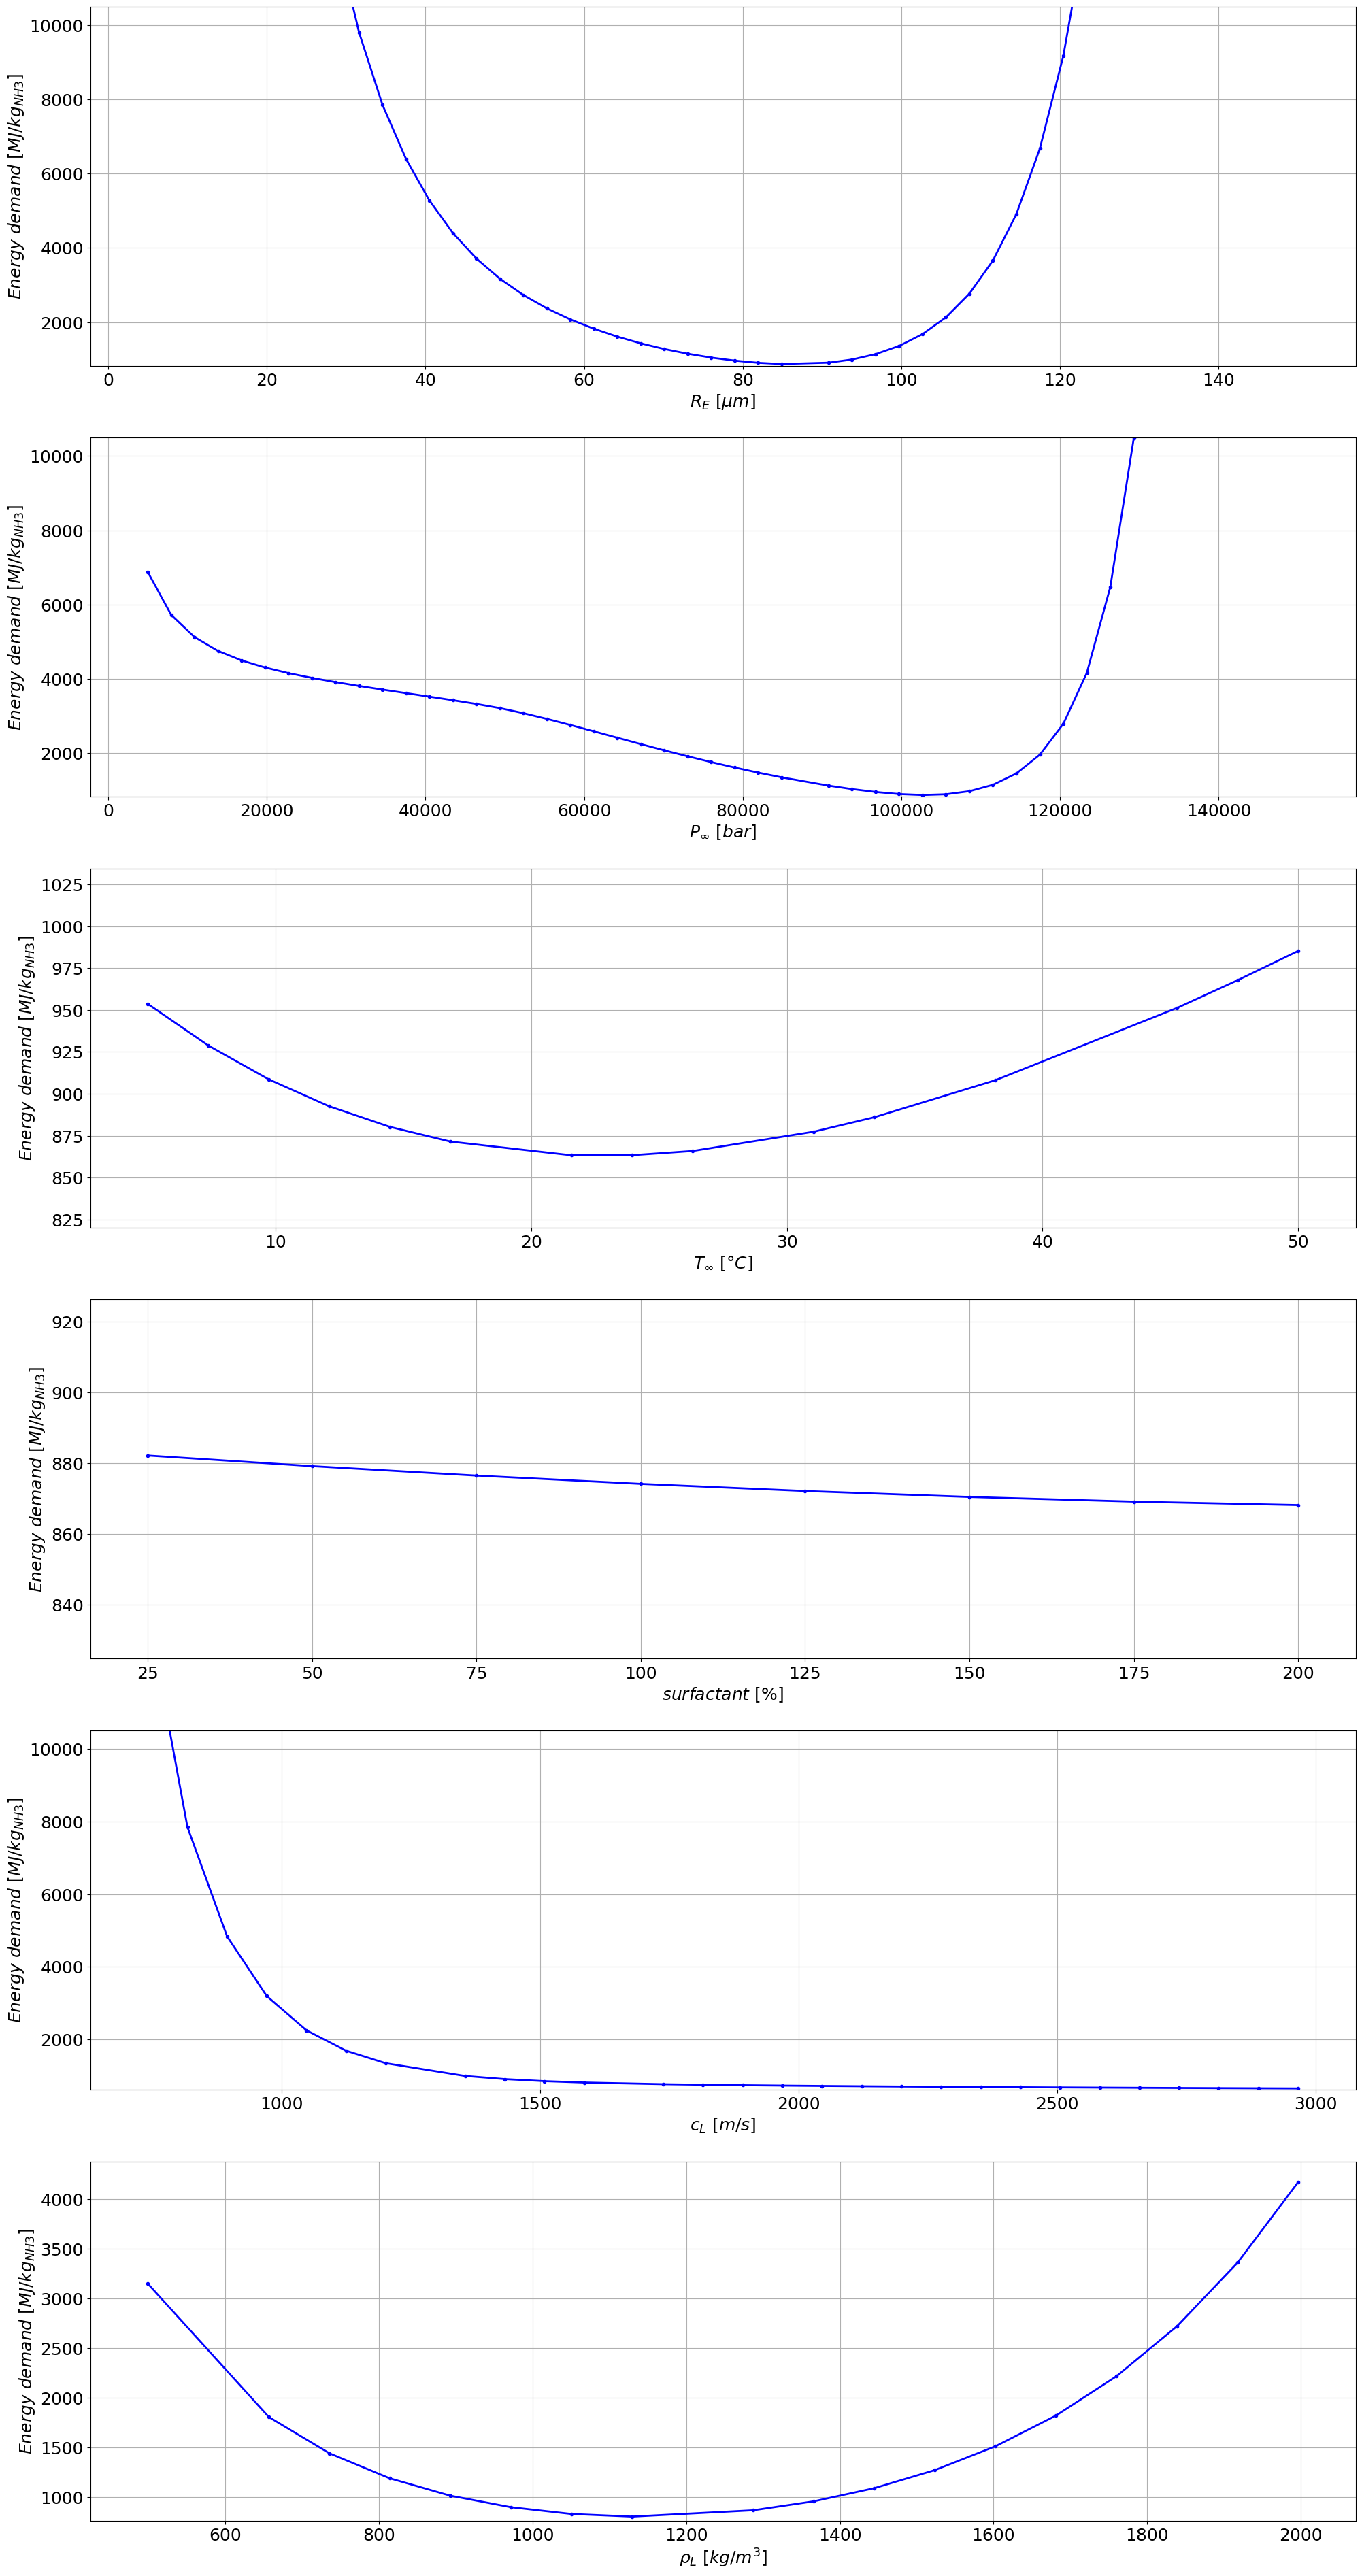

In [65]:
"""Plot the results (and save it as .png)"""

plt.rcParams.update({'font.size': 18})

n = len(kwargs_list)
fig, ax = plt.subplots(n, 1, figsize=(24, 8*n))
for i, key in enumerate(ranges):
    subx = x[i]
    suby = y[i]
    
  # unit corrections:
    correction1 = 1.0   
    correction2 = 0.0
    if key=='R_E': correction1 = 1e6
    elif key=='P_inf': correction1 = 1e-5
    elif key=='T_inf': correction2 = -273.15
    elif key=='surfactant': correction1 = 100.0
    subx = correction1 * np.array(subx) + correction2
    
  # ploting:
    ax[i].plot(subx, suby, '.-', color='b', linewidth=2.0)
    ax[i].set_ylabel('$Energy\ demand\ [MJ/kg_{' + de.target_specie + '}]$')
    ax[i].set_xlabel(labels[key])
    ax[i].set_ylim([max(0.0, 0.95*min(suby)), 1.05*min(max(suby), 1e4)])
    #ax[i].set_yscale('log')
    ax[i].grid()
  # add the red dot:
    ax[i].plot(correction1*best_point[key]+correction2, fixed_energy, markersize=12, marker="o", color='r')

if False: # save as image by setting it True (don't forget to create folder named 'images')
    fig.savefig('images\\cpars-Energy-plot.png')

## Multiple graphs on the same plot
In this example, you have one control parameter along the x axis, just like in the first example. But the effect of a second control parameter can be examined by creating multiple graphs, with different values of the second parameter. <br> 
In this example:

* **x**: Equilibrium radius or $R_E\ [\mu m]$ <br>
* **second cpar**: Ambient pressure or $P_\infty\ [bar]$ <br>
* **y**: Energy requirement for the production of 1 kg hydrogen or $E\ [MJ/kg]$ <br>

In [66]:
"""Control parameters"""

# Equilibrium radius: [um --> m]
parname1 = 'R_E'
ranges1 = [1e-6*x for x in list(np.linspace(40.0, 110.0, 30))]
# Ambient pressure: [bar --> Pa]
parname2 = 'P_amb'
ranges2 = [1e5*x for x in [0.05, 0.15, 0.25, 0.35, 0.45, 0.55]]

# list all cpar combinations you want to plot:
kwargs_list = []
ID = 1
for value2 in ranges2:
    cpars = []
    for value1 in ranges1:
        cpar = de.copy(best_point)  # deep copy other_cpars
        cpar[parname1] = value1
        cpar[parname2] = value2
        cpar['ID'] = ID
        ID += 1
        cpar['P_v'] = de.VapourPressure(T=cpar['T_inf']) # [Pa]
        cpar['mu_L'] = de.Viscosity(T=cpar['T_inf']) # [Pa*s]
        cpars.append(cpar)
    # Create input dictionary for de.simulate(), a list of dictionaries with cpar and other arguments
    kwargs_list.append([dict(cpar=cpar, t_int=np.array([0.0, 1.0]), LSODA_timeout=30, Radau_timeout=300) for cpar in cpars])

In [67]:
"""Run simulations, multithread"""
# calculate E [MJ/kg] for each combinations
# use Pool(processes=cpu_count()-1) to limit number of threads being used.
# use pool.imap(...) instead of pool.imap_unordered(...) to preserve order in which cpars was made

# empty lists to store values on x and y axises:
x = []
y = []

best_energy = 1e30
num = sum([len(x) for x in kwargs_list])
start = time.time()
for i in range(len(ranges2)):
    subx = []
    suby = []
    with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
        results = pool.imap(de.simulate, kwargs_list[i])

        for data in results:
            # store results in x and y, if they are valid:
            data = de.dotdict(data)
            if data.success==True and data.energy_demand==data.energy_demand: # if simulation is succesfull, and energy is not NaN
                if data.energy_demand<0: data.energy_demand=1e30
                subx.append(data[parname1])
                suby.append(data.energy_demand)
            # print stuff:
            if data.energy_demand>0 and data.energy_demand<best_energy:
                best_energy = data.energy_demand
            excitation_params = ''.join([f'{key}={data[key]: <12}; ' for key in de.excitation_args])
            print(f'index: {data.ID: >8}/{num};   error_code: {data.error_code: >4};   steps: {data.steps: <8};   runtime: {data.elapsed_time: 6.2f} [s]   |   '+
                f'R_E={1e6*data.R_E: 6.2f} [um]; ratio={data.ratio: 6.2f} [-]; P_amb={1e-5*data.P_amb: 6.2f} [bar]; T_inf={data.T_inf-273.15: 6.2f} [°C]; '+
                f'alfa_M={data.alfa_M: 6.2f} [-]; P_v={data.P_v: 6.0f} [Pa]; mu_L={data.mu_L: 6.5f} [Pa*s]; rho_L={data.rho_L: 6.1f} [kg/m^3]; c_L={data.c_L: 6.0f} [m/s]; '+
                f'surfactant={100*data.surfactant: 3.0f} [%]   |   {excitation_params}   |   '+
                f'{de.target_specie} production: {data.energy_demand: e} [MJ/kg]'+
                '                                                 ', end='\r')
    x.append(subx)
    y.append(suby)
            
end = time.time()
elapsed = end - start   
print(f'\n\nDONE')
print(f'total time: {(elapsed / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / num): .2f} [s/run])')
good = sum([len(x) for x in x])
print(f'succes: {good}/{num}')

index:      180/180;   error_code:    0;   steps: 16367   ;   runtime:   1.39 [s]   |   R_E= 110.00 [um]; ratio=  1.00 [-]; P_amb=  0.55 [bar]; T_inf= 30.00 [°C]; alfa_M=  0.35 [-]; P_v=  4245 [Pa]; mu_L= 0.00081 [Pa*s]; rho_L= 998.2 [kg/m^3]; c_L=  1483 [m/s]; surfactant= 100 [%]   |   p_A=-187401.99765485013; freq=12000.0     ; n=1.0         ;    |   NH3 production:  1.293947e+03 [MJ/kg]                                                 

DONE
total time:  0 hours  3 mins
             194.19 [s]   ( 1.08 [s/run])
succes: 180/180


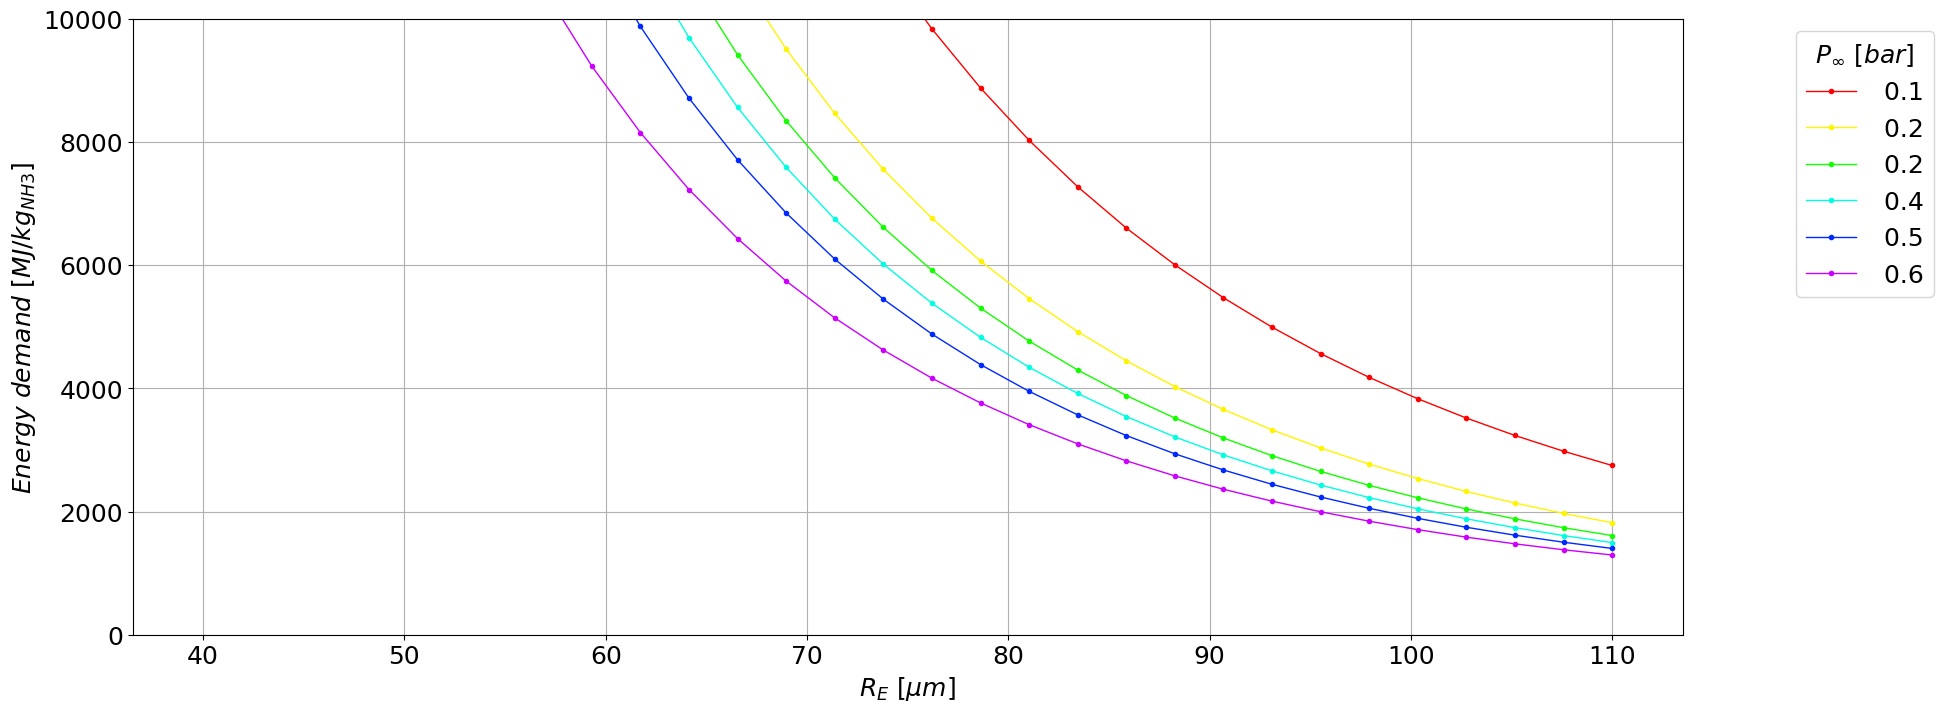

In [68]:
"""Plot the results (and save it as .png)"""

plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.set_ylabel('$Energy\ demand\ [MJ/kg_{' + de.target_specie + '}]$')
ax.set_xlabel('$R_E \ [\mu m]$')
ax.set_ylim([0, 1e4])
#ax.set_yscale('log')
ax.grid()

delta = max(ranges2) - min(ranges2)
minimum = min(ranges2)
for i, value in enumerate(ranges2):
    value = 0.8 * (value - minimum) / delta
    ax.plot(1e6*np.array(x[i]), y[i], '.-', color=hsv_to_rgb((value, 1.0, 1.0)), linewidth=1.0)
    
ax.legend([f'{P_inf*1e-5: .1f}' for P_inf in ranges2], title='$P_\infty\ [bar]$', loc ="upper right", bbox_to_anchor=(1.17, 1))
if False: # save as image by setting it True (don't forget to create folder named 'images')
    fig.savefig('images\\R_E-P_inf-Energy-plot.png')